In [849]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [850]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn import svm
import pywt
import copy
import warnings
from statsmodels.tsa.arima_model import ARIMA, ARIMAResults, ARMA
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf, pacf, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pylab as plt
from matplotlib import pyplot
import matplotlib.dates as dates
from matplotlib.pylab import rcParams
from pmdarima.arima import auto_arima
from sklearn.metrics import explained_variance_score, mean_absolute_error, mean_squared_error, r2_score

In [851]:
# Đọc chuỗi thời gian
path = '/content/gdrive/MyDrive/Colab Notebooks/Times Series Analysit/code/Stock_Index_BBC.csv'
df = pd.read_csv(path, header = 0)
stock = df['CLOSE'] 

In [852]:
df['DATE'] = pd.to_datetime(df['DATE'], format='%m/%d/%Y')
df.set_index(['DATE'], inplace=True)

In [853]:
train = df.loc[:'10/25/2021',:]
data_train = train['CLOSE'].to_numpy()
data_test = df.loc['10/26/2021':,:]
data_train

array([3342.2272, 3368.3117, 3367.7892, 3347.6665, 3363.9014, 3358.2716,
       3334.4954, 3317.6241, 3319.9122, 3319.4455, 3326.3563, 3339.3653,
       3329.2891, 3354.8891, 3364.0808, 3364.4509, 3375.9042, 3387.9606,
       3364.4923, 3373.2051, 3365.6849, 3383.2878, 3396.2924, 3413.4868,
       3436.275 , 3435.8042, 3421.7131, 3440.9331, 3421.4419, 3471.3926,
       3482.823 , 3489.7567, 3473.3236, 3473.8517, 3446.2228, 3452.8103,
       3458.4376, 3435.0963, 3427.8628, 3446.484 , 3453.9565, 3448.7313,
       3426.9438, 3427.8916, 3458.098 , 3456.6934, 3463.6436, 3481.5066,
       3445.8051, 3449.6126, 3466.3468, 3450.0502, 3461.9782, 3489.5997,
       3478.0385, 3469.8093, 3465.1933, 3436.758 , 3456.0455, 3503.8932,
       3514.0469, 3517.4634, 3505.1392, 3517.328 , 3509.4387, 3514.5662,
       3486.5045, 3479.9417, 3462.7429, 3445.8761, 3461.5481, 3466.7865,
       3431.2587, 3440.9743, 3445.1832, 3446.7202, 3439.753 , 3426.5766,
       3413.1282, 3404.3864, 3382.5502, 3358.8125, 

#NHAP



In [854]:
# cA, cD3, cD2, cD1, cD0 = pywt.wavedec(test_C, 'db2', level=4)
# print(cA)

In [855]:
# print('low frequency')
# acf_cA = plot_acf(cA)
# pacf_cA = plot_pacf(cA)

In [856]:
# acf_D = plot_acf(cD3)
# pacf_D = plot_pacf(cD3)

# acf_D = plot_acf(cD2)
# pacf_D = plot_pacf(cD2)

# acf_D = plot_acf(cD1)
# pacf_D = plot_pacf(cD1)

# acf_D = plot_acf(cD0)
# pacf_D = plot_pacf(cD0)

In [857]:
# stepwise_model_A = auto_arima(data_A, start_p=1, start_q=1,
#                            max_p=10, max_q=10,max_d=10, m=30,
#                            start_P=0, seasonal=True,
#                            start_d=1, trace=True,
#                            error_action='ignore',  
#                            suppress_warnings=True, 
#                            stepwise=True)
# print(stepwise_model_A.aic())

In [858]:
# model_cA = ARIMA(cA, order=(2,1,0)).fit()
# model_cA
# forecastA, stdA, conf_intA = model_cA.forecast(steps=7) 
# forecastA

In [859]:
# model_cD3 = ARIMA(cD3, order=(1,0,1)).fit()
# model_cD3
# forecastD3, stdD3, conf_intD3 = model_cD3.forecast(steps=7) 
# forecastD3

In [860]:
# model_cD2 = ARIMA(cD2, order=(0,0,1)).fit()
# model_cD2
# forecastD2, stdD2, conf_intD2 = model_cD2.forecast(steps=7) 
# forecastD2

#MAIN

In [861]:
def WT(index_list, wavefunc='db4', lv=9, m=1, n=4, plot=False):
   
    # Decomposing 
    coeff = pywt.wavedec(index_list,wavefunc,mode='sym',level=lv)   #  Decomposing by levels，cD is the details coefficient
    sgn = lambda x: 1 if x > 0 else -1 if x < 0 else 0 # sgn function 

    #plt.plot(coeff[8])

    # Denoising
    # Soft Threshold Processing Method
    for i in range(m,n+1):   #  Select m~n Levels of the wavelet coefficients，and no need to dispose the cA coefficients(approximation coefficients)
        cD = coeff[i]
        Tr = np.sqrt(2*np.log2(len(cD)))  # Compute Threshold
        for j in range(len(cD)):
            if cD[j] >= Tr:
                coeff[i][j] = sgn(cD[j]) * (np.abs(cD[j]) -  Tr)  # Shrink to zero
            else:
                coeff[i][j] = 0   # Set to zero if smaller than threshold

    # Reconstructing
    coeffs = {}
    for i in range(len(coeff)):
        coeffs[i] = copy.deepcopy(coeff)
        for j in range(len(coeff)):
            if j != i:
                coeffs[i][j] = np.zeros_like(coeff[j])
    
    for i in range(len(coeff)):
        coeff[i] = pywt.waverec(coeffs[i], wavefunc)
        if len(coeff[i]) > len(index_list):
            coeff[i] = coeff[i][:-1]
        
    if plot:     
        denoised_index = np.sum(coeff, axis=0)   
        data = pd.DataFrame({'CLOSE': index_list, 'denoised': denoised_index})
        data.plot(figsize=(10,10),subplots=(2,1))
        data.plot(figsize=(10,5))
   
    return coeff

/usr/local/lib/python3.7/dist-packages/pywt/_multilevel.py:45: UserWarning: Level value of 9 is too high: all coefficients will experience boundary effects.
  "boundary effects.").format(level))


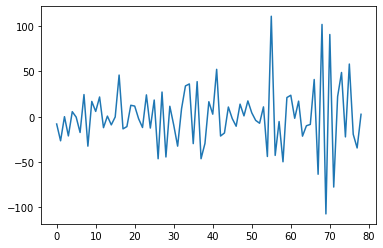

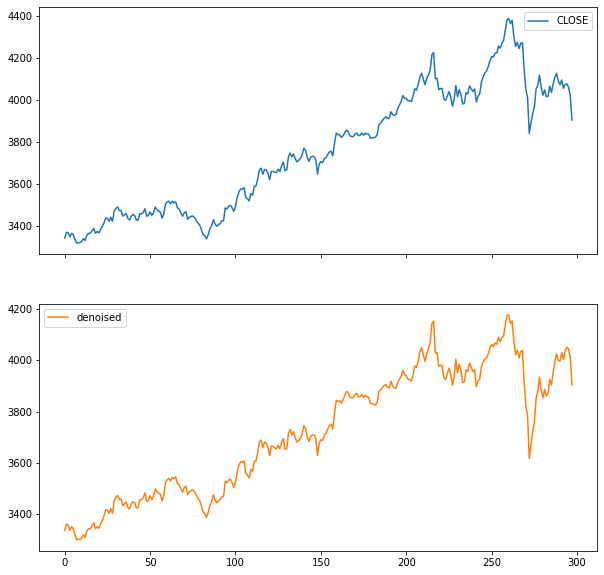

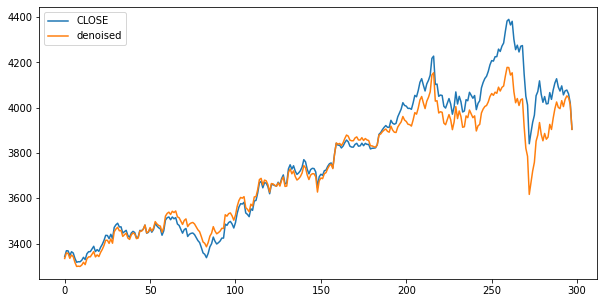

In [862]:
coeff = WT(data_train, plot=True)
rec_ = np.sum(coeff, axis=0)  
rec_data = pd.DataFrame(rec_, index = train.index)

                      0
DATE                   
2021-01-01  3334.149761
2021-01-02  3358.729200
2021-01-03  3356.644726
2021-01-04  3334.898462
2021-01-05  3349.497818
...                 ...
2021-10-21  4036.608651
2021-10-22  4052.036522
2021-10-23  4045.054860
2021-10-24  4012.856432
2021-10-25  3903.996425

[298 rows x 1 columns]


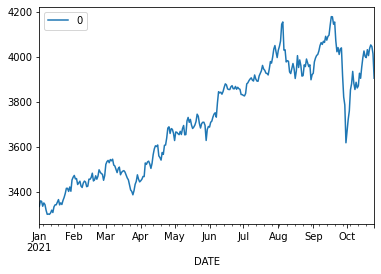

In [863]:
rec_data.plot()
print(rec_data)

Text(0.5, 1.0, 'ACF Plot of  reconstruction Stock Index BBC data ')

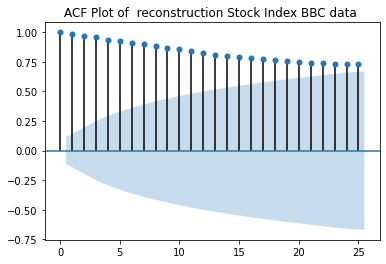

In [864]:
acf_recdata = plot_acf(rec_data)
plt.title("ACF Plot of  reconstruction Stock Index BBC data ")

Text(0.5, 1.0, 'PACF Plot of  reconstruction Stock Index BBC data ')

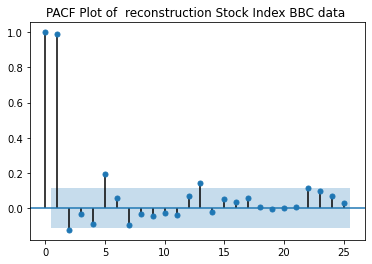

In [865]:
pacf_recdata = plot_pacf(rec_data)
plt.title("PACF Plot of  reconstruction Stock Index BBC data ")

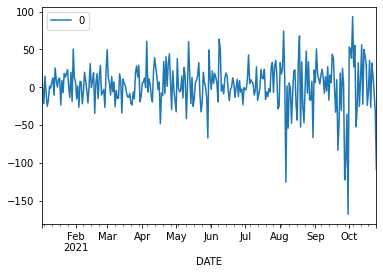

In [866]:
diff1 = rec_data - rec_data.shift(1)
diff1 = diff1.dropna()
diff1.plot()

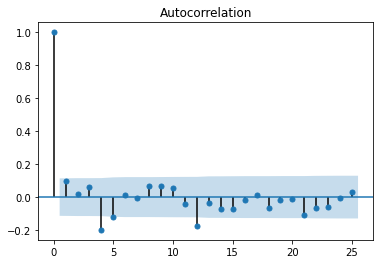

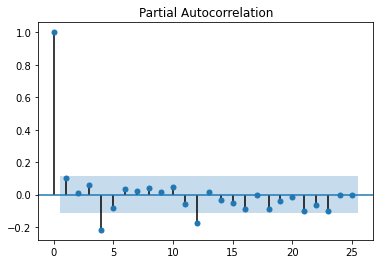

In [867]:
acf_diff1 = plot_acf(diff1)
pacf_diff1 = plot_pacf(diff1)

In [868]:
# stepwise_model_A = auto_arima(rec_data, start_p=1, start_q=1,
#                            max_p=10, max_q=10,max_d=10, m=1,
#                            start_P=0, seasonal=True,
#                            start_d=1, trace=True,
#                            error_action='ignore',  
#                            suppress_warnings=True, 
#                            stepwise=True)
# print(stepwise_model_A.aic())

In [869]:
print(rec_data)

                      0
DATE                   
2021-01-01  3334.149761
2021-01-02  3358.729200
2021-01-03  3356.644726
2021-01-04  3334.898462
2021-01-05  3349.497818
...                 ...
2021-10-21  4036.608651
2021-10-22  4052.036522
2021-10-23  4045.054860
2021-10-24  4012.856432
2021-10-25  3903.996425

[298 rows x 1 columns]


In [870]:
 mod = ARIMA(rec_data.values, order=(1,1,1))
 result  = mod.fit()
 forcast, std, conf_int =  result.forecast(5)
 print(forcast)

[3893.95279003 3893.09183213 3894.3396647  3896.07177843 3897.91510672]


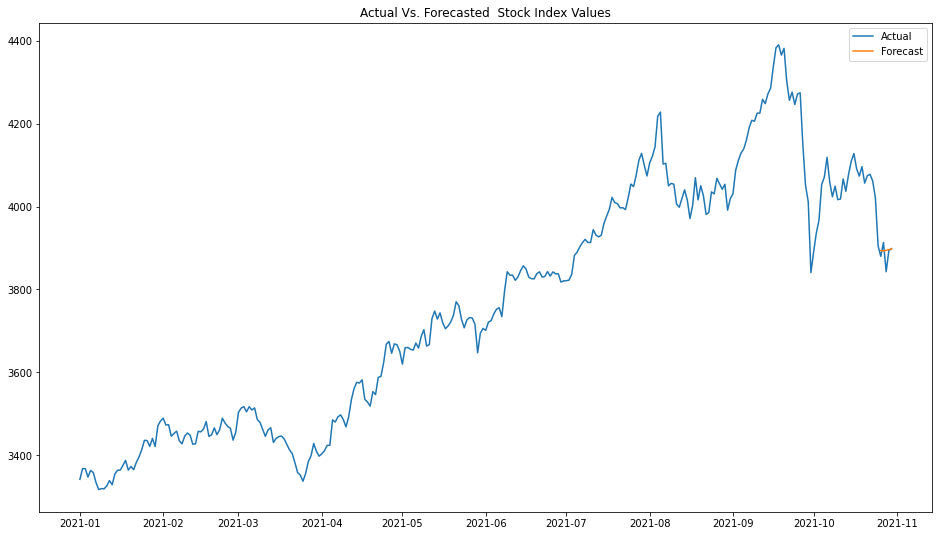

In [871]:
Stock_for1 = pd.Series(forcast, index = data_test.index)

plt.figure(figsize=(16,9))
plt.plot(df.index, df['CLOSE'])
plt.plot(Stock_for1.index,Stock_for1.values)
plt.legend(['Actual', 'Forecast'])
plt.title('Actual Vs. Forecasted  Stock Index Values')
plt.show()

Validation

In [872]:
def MAPE(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [873]:
print("MSE: {0:.3f}" .format(mean_squared_error(data_test.values, forcast)))
print("RMSE: {0:.3f}" .format(np.sqrt(mean_squared_error(data_test.values, forcast))))
print("MAE:{0:.3f}".format(mean_absolute_error(data_test.values, forcast)))
print("MAPE:{0:.3f}" .format(MAPE(data_test.values, forcast),"%"))

MSE: 654.855
RMSE: 25.590
MAE:17.693
MAPE:0.469
